# Week 9. Time Series

* Time series data is an important form of structured data in finance. <br>
   * Time-series of stock returns
   * Time-series of accounting information at different quarters  <br>
<br>
* In this section, you will learn how to handle time serie data in pandas. 
   * ```datetime``` object and its functionality
   * Resampling and frequency conversion
   * Moving window functions

In [1]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(6, 3))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

---

## 9.1 Date and Time Data Types and Tools

In [2]:
from datetime import datetime
now = datetime.now()
print(now)
now.year, now.month, now.day

2024-12-12 22:18:03.840867


(2024, 12, 12)

* ```datetime``` stores both the date and time down to the **microsecond**.
  
* ```timedelta``` represents the temporal difference between two ```datetime``` objects.

* ```datetime(2011, 1, 7)```: Jan 7, 2011
* ```datetime(2008, 6, 24, 8, 15)```: 8:15AM June 24, 2008

In [3]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
#delta = datetime(2011, 1, 7, 0, 0) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(days=926, seconds=56700)

In [4]:
delta.days

926

In [5]:
delta.seconds

56700

You can add (or subtract) a ```timedelta``` to a ```datetime``` object to yield a new **shifted** object:

In [6]:
from datetime import timedelta

In [7]:
timedelta(1)

datetime.timedelta(days=1)

In [8]:
start = datetime(2011, 1, 7)
print(start + timedelta(12))       # shift 12 days forwards
print(start - 2 * timedelta(12))

2011-01-19 00:00:00
2010-12-14 00:00:00


### 9.1.1 Converting Between String and Datetime

You can format ```datetime``` objects as strings using ```str``` or the ```strftime``` method, passing a format specification:

In [9]:
stamp = datetime(2011, 1, 3)
print(str(stamp))
print(stamp.strftime('%Y-%m-%d'))
print(stamp.strftime('%Y-%m-%d-%H'))

2011-01-03 00:00:00
2011-01-03
2011-01-03-00


**Datetime format specification**

* ```%Y``` Four-digit year
* ```%y``` Two-digit year
* ```%m``` Two-digit month [01, 12] 
* ```%d``` Two-digit day [01, 31]
* ```%H``` Hour (24-hour clock) [00, 23]
* ```%I``` Hour (12-hour clock) [01, 12]
* ```%M``` Two-digit minute [00, 59]
* ```%S``` Second [00, 61] (seconds 60, 61 account for leap seconds) 
* ```%w``` Weekday as integer [0 (Sunday), 6]
* ```%U``` Week number of the year [00, 53]; 
  * Sunday is considered the first day of the week, and days before the first Sunday of the year are “week 0”
* ```%W``` Week number of the year [00, 53]; 
  * Monday is considered the first day of the week, and days before the first Monday of the year are “week 0”
* ```%F``` Shortcut for ```%Y-%m-%d``` (e.g.,2012-4-18)
* ```%D``` Shortcut for ```%m/%d/%y``` (e.g.,04/18/12)

You can use these same format codes to convert strings to dates using date ```time.strptime```:

In [10]:
value = '2011-01-03'   
print(datetime.strptime(value, '%Y-%m-%d'))

2011-01-03 00:00:00


In [11]:
datestrs = ['7/6/2011', '8/6/2011']
print([datetime.strptime(x, '%m/%d/%Y') for x in datestrs])

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]


```pandas``` is generally oriented toward working with arrays of dates, whether used as an axis index or a column in a DataFrame. <br>
<br>
* The ```pandas.to_datetime``` method parses many different kinds of date representations.

In [12]:
datestrs = ['2011-07-06 12:00:00', '2011-08-06 00:00:00']
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

It also handles values that should be considered missing (```None```, empty string, etc.):

In [13]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

```NaT``` (**Not a Time**) is pandas’s null value for timestamp data

In [14]:
idx[2]

NaT

In [15]:
pd.isnull(idx)

array([False, False,  True])

---

## 9.2 Time Series Basics

A basic kind of time series object in pandas is a Series indexed by ```timestamps```, often represented as Python strings or ```datetime``` objects:

In [16]:
from datetime import datetime
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),
         datetime(2011, 1, 7), datetime(2011, 1, 8),
         datetime(2011, 1, 10), datetime(2011, 1, 12)]
ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [17]:
ts.index   # Under the hood, these datetime objects have been put in a DatetimeIndex:

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

Like other Series, arithmetic operations between differently indexed time series automatically **align on the dates**:

In [18]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [19]:
ts - ts[::2]   # Recall that ts[::2] selects every second element in ts.

2011-01-02    0.0
2011-01-05    NaN
2011-01-07    0.0
2011-01-08    NaN
2011-01-10    0.0
2011-01-12    NaN
dtype: float64

Scalar values from a ```DatetimeIndex``` are pandas ```Timestamp``` objects:

In [20]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

### 9.2.1 Indexing and Slicing

In [21]:
stamp = ts.index[2]
ts[stamp]

np.float64(-0.5194387150567381)

As a convenience, you can also pass a string that is interpretable as a date:

In [22]:
ts['1/10/2011']

np.float64(1.9657805725027142)

In [23]:
ts['20110110']

np.float64(1.9657805725027142)

In [24]:
longer_ts = pd.Series(np.random.randn(1000),
                      index=pd.date_range('1/1/2000', periods=1000))
#longer_ts

As before, you can pass either a string date, datetime, or timestamp to slice a pd.Series. 

In [25]:
longer_ts['2001']   # select all instances in year 2001

2001-01-01    1.599534
2001-01-02    0.474071
2001-01-03    0.151326
2001-01-04   -0.542173
2001-01-05   -0.475496
                ...   
2001-12-27    0.057874
2001-12-28   -0.433739
2001-12-29    0.092698
2001-12-30   -1.397820
2001-12-31    1.457823
Freq: D, Length: 365, dtype: float64

In [26]:
longer_ts['2001-05']   # select all instances in May, 2001

2001-05-01   -0.622547
2001-05-02    0.936289
2001-05-03    0.750018
2001-05-04   -0.056715
2001-05-05    2.300675
                ...   
2001-05-27    0.235477
2001-05-28    0.111835
2001-05-29   -1.251504
2001-05-30   -2.949343
2001-05-31    0.634634
Freq: D, Length: 31, dtype: float64

Slicing with ```datetime``` objects works as well:

In [27]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [28]:
ts[datetime(2011, 1, 7):]

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

You can slice with timestamps not contained in a time series to perform a range query
* When you do the slicing using labels, the end point is ***inclusive***

In [29]:
print(ts)
ts['1/6/2011':'1/10/2011']  

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64


2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
dtype: float64

---

## 9.3 Date Ranges, Frequencies, and Shifting

### 9.3.1 Generating Date Ranges

```pandas.date_range``` is responsible for generating a ```DatetimeIndex``` with an indicated length according to a particular frequency:
* Unlike ```range``` and ```np.arange```, the end point is inclusive in ```pd.date_range```  <br>
<br>
* By default, the frequency in ```pd.date_range``` is ```'D'``` (a day)

In [30]:
index = pd.date_range('2012-04-01', '2012-06-01')
#index

In [31]:
pd.date_range(start='2012-04-01', periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

You can change the frequency of the time series by specifying ```freq```

In [54]:
pd.date_range('2000-01-01', '2000-12-01', freq='ME')   # 'M' frequency: end of month

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='ME')

### 9.3.2 Shifting (Leading and Lagging) Data

Both Series and DataFrame have a ```shift``` method for doing naive shifts forward or backward, leaving the index unmodified. 

In [33]:
ts = pd.Series(np.random.randn(4),
               index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\881163876.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.date_range('1/1/2000', periods=4, freq='M'))


2000-01-31    0.488675
2000-02-29   -0.178098
2000-03-31    2.122315
2000-04-30    0.061192
Freq: ME, dtype: float64

In [34]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31    0.488675
2000-04-30   -0.178098
Freq: ME, dtype: float64

In [35]:
ts.shift(-2)

2000-01-31    2.122315
2000-02-29    0.061192
2000-03-31         NaN
2000-04-30         NaN
Freq: ME, dtype: float64

In [36]:
ts / ts.shift(1) - 1

2000-01-31          NaN
2000-02-29    -1.364451
2000-03-31   -12.916540
2000-04-30    -0.971167
Freq: ME, dtype: float64

* Because naive shifts leave the index unmodified, some data is discarded.  <br> 
<br>
* If the frequency is known, it can be passed to ```shift``` to advance the timestamps instead of simply the data:

In [37]:
ts

2000-01-31    0.488675
2000-02-29   -0.178098
2000-03-31    2.122315
2000-04-30    0.061192
Freq: ME, dtype: float64

In [38]:
ts.shift(2, freq='M')   # also shift the index

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\1697720620.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts.shift(2, freq='M')   # also shift the index


2000-03-31    0.488675
2000-04-30   -0.178098
2000-05-31    2.122315
2000-06-30    0.061192
Freq: ME, dtype: float64

In [39]:
ts.shift(3, freq='D')

2000-02-03    0.488675
2000-03-03   -0.178098
2000-04-03    2.122315
2000-05-03    0.061192
dtype: float64

#### Shifting dates with offsets

If you add an anchored offset like ```MonthEnd```, the first increment will “roll forward” a date to the next date according to the frequency rule.

In [ ]:
from pandas.tseries.offsets import Day, MonthEnd
now = datetime(2011, 11, 17)
now

datetime.datetime(2011, 11, 17, 0, 0)

In [55]:
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

In [56]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [57]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

#### When is the ```MonthEnd``` useful?

* We observe data from different sources on different days in the same month  <br>
<br>
* To merge the different datasets at monthly frequencies, we need to first of all convert all the datatime object to the month end

---

## 9.4 Resampling and Frequency Conversion

**Resampling** refers to the process of converting a time series from one frequency to another. <br>
<br>
 * Aggregating higher frequency data to lower frequency is called **downsampling**
    * Example: calculate the cumulative monthly return using daily stock returns   <br>
 <br>
 * Converting lower frequency to higher frequency is called **upsampling**
    * Example: Use quarterly accounting data to predict monthly stock returns

### 9.4.1 Downsampling

In [58]:
rng = pd.date_range('2000-01-01', periods=100, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2000-01-01    0.160301
2000-01-02   -0.712900
2000-01-03   -0.308272
2000-01-04    0.317635
2000-01-05    2.458842
                ...   
2000-04-05   -0.544736
2000-04-06    0.977949
2000-04-07   -0.256382
2000-04-08    0.510783
2000-04-09    0.720283
Freq: D, Length: 100, dtype: float64

* pandas objects are equipped with a ```resample``` method.  <br>
<br>
* ```resample``` has a similar API to ```groupby```; you call ```resample``` to group the data, then call an aggregation function:

In [59]:
ts.resample('M').mean()

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\2305925915.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts.resample('M').mean()


2000-01-31   -0.022255
2000-02-29   -0.381338
2000-03-31   -0.177826
2000-04-30   -0.058285
Freq: ME, dtype: float64

```python
for time, chunk in ts.resample('M'):
    print("-------------------------")
    print(time)
    print(chunk.head())
    print("the mean at time", time, 'is', chunk.mean())
```

In [60]:
ts.resample('M', kind='period').mean()

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\1597458493.py:1: FutureWarning: The 'kind' keyword in Series.resample is deprecated and will be removed in a future version. Explicitly cast the index to the desired type instead
  ts.resample('M', kind='period').mean()
C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\1597458493.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts.resample('M', kind='period').mean()


2000-01   -0.022255
2000-02   -0.381338
2000-03   -0.177826
2000-04   -0.058285
Freq: M, dtype: float64

In [61]:
ts.resample('M', kind='period').sum()

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\8010482.py:1: FutureWarning: The 'kind' keyword in Series.resample is deprecated and will be removed in a future version. Explicitly cast the index to the desired type instead
  ts.resample('M', kind='period').sum()
C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\8010482.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts.resample('M', kind='period').sum()


2000-01    -0.689900
2000-02   -11.058793
2000-03    -5.512617
2000-04    -0.524567
Freq: M, dtype: float64

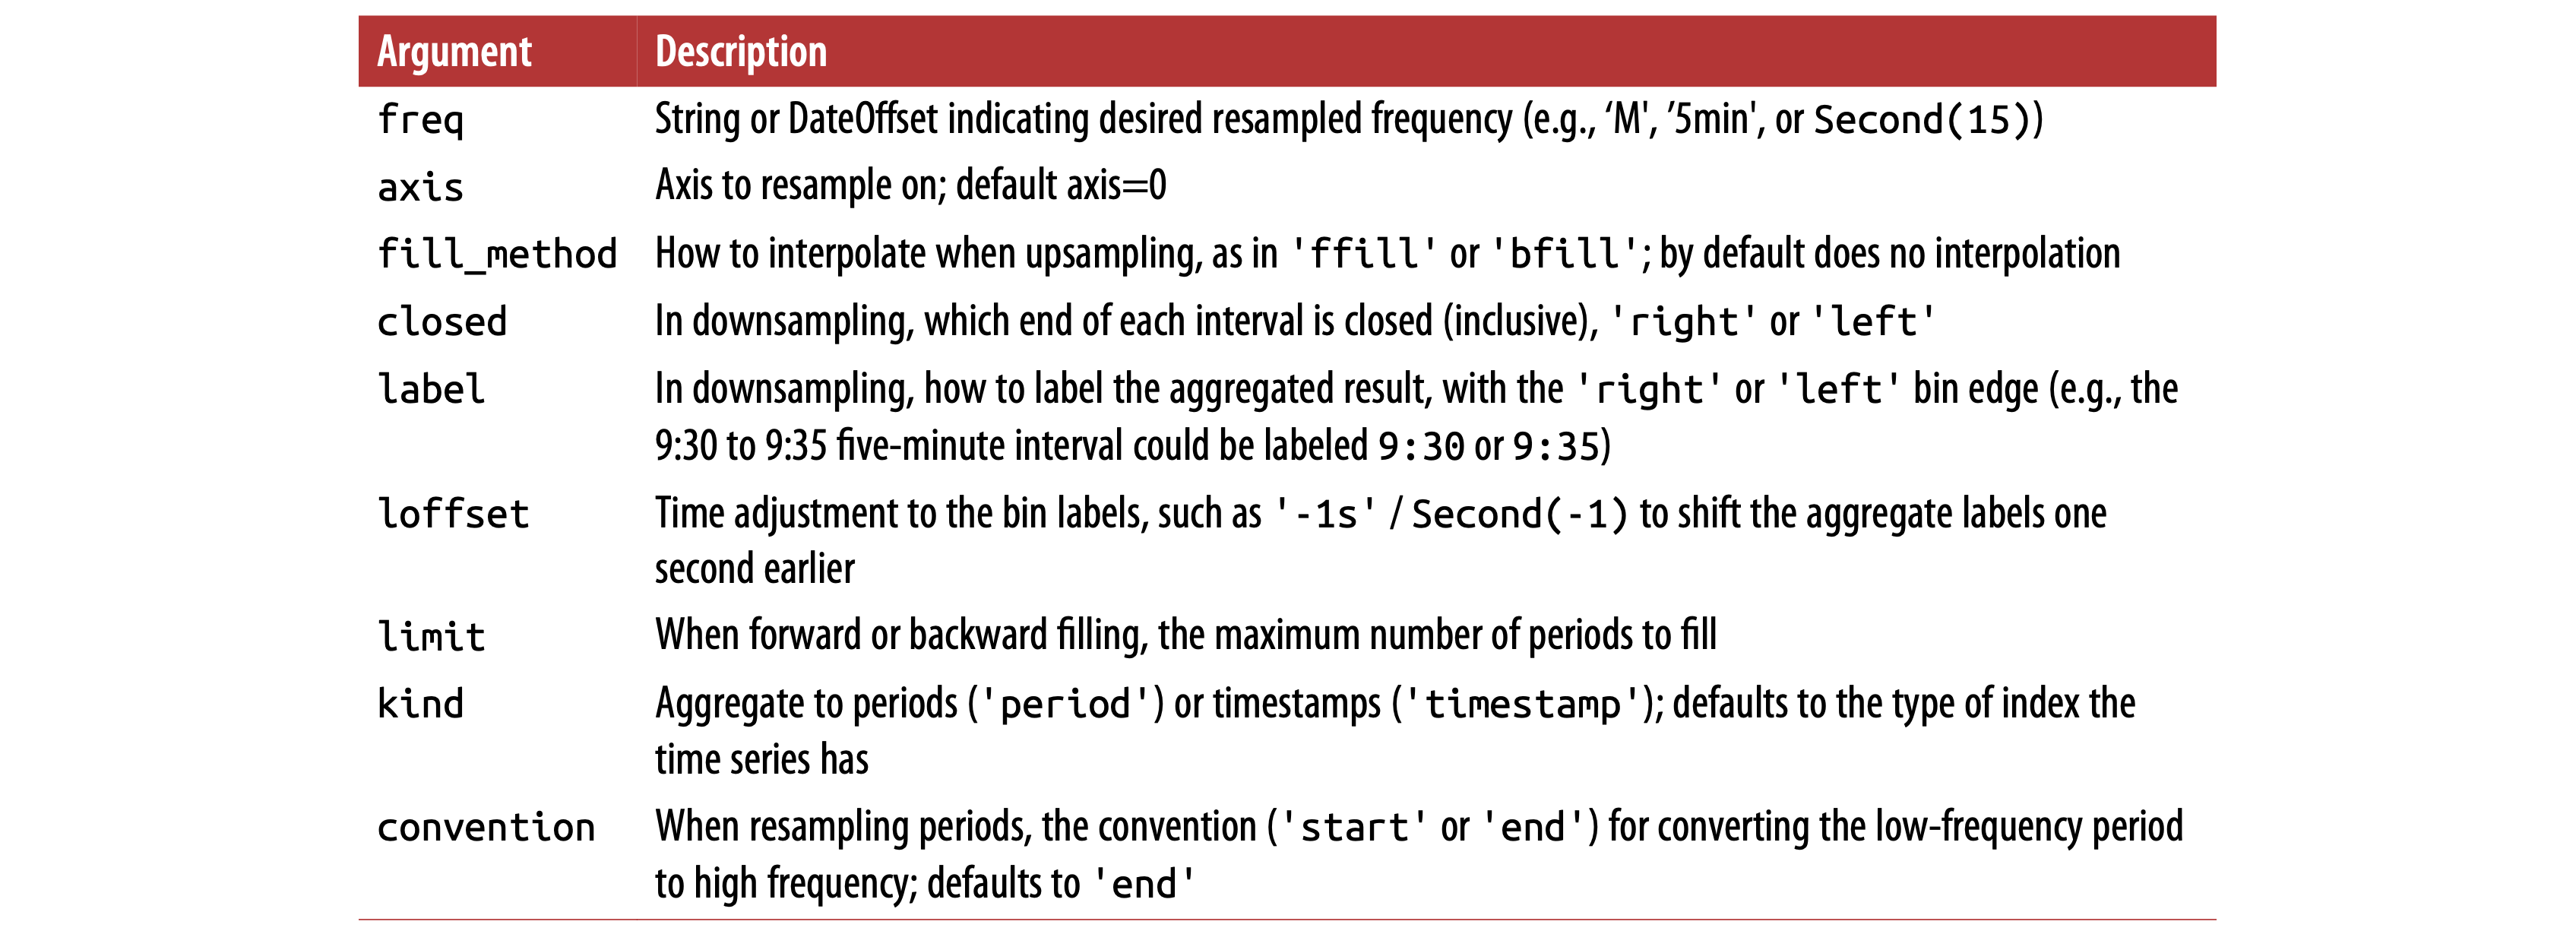

### 9.4.2 Upsampling and Interpolation

When converting from a low frequency to a higher frequency, no aggregation is needed (no need to use ```mean```, ```sum```, etc.). 

In [62]:
frame = pd.DataFrame(np.random.randn(2, 4),
                     index=pd.date_range('1/1/2020', periods=2, freq='Q'),
                     columns=['Apple', 'Microsoft', 'Nvidia', 'Meta'])
frame

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\2597217358.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  index=pd.date_range('1/1/2020', periods=2, freq='Q'),


,Apple,Microsoft,Nvidia,Meta
2020-03-31,0.380877,1.003401,-2.315555,0.457246
2020-06-30,-0.025907,-3.399312,-0.974657,-0.685312


We use the ```asfreq``` method to convert to the higher frequency without any aggregation:

In [63]:
df_monthly = frame.resample('M').asfreq()
df_monthly

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\1418183840.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = frame.resample('M').asfreq()


,Apple,Microsoft,Nvidia,Meta
2020-03-31,0.380877,1.003401,-2.315555,0.457246
2020-04-30,NaN,NaN,NaN,NaN
2020-05-31,NaN,NaN,NaN,NaN
2020-06-30,-0.025907,-3.399312,-0.974657,-0.685312


Suppose that we want to use the forward-fill (```ffill```) to handle the missing data in ```df_monthly```
* In Apr 2020, we want to use the most up-to-date information (the observable in Mar 2020) to fill in the missing data

In [64]:
frame.resample('M').ffill()

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\3454177591.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  frame.resample('M').ffill()


,Apple,Microsoft,Nvidia,Meta
2020-03-31,0.380877,1.003401,-2.315555,0.457246
2020-04-30,0.380877,1.003401,-2.315555,0.457246
2020-05-31,0.380877,1.003401,-2.315555,0.457246
2020-06-30,-0.025907,-3.399312,-0.974657,-0.685312


In [65]:
frame.resample('M').ffill(limit=1)   # You can similarly choose to only fill a certain number of periods 
                                     # forward to limit how far to continue using an observed value

C:\Users\Hatim\AppData\Local\Temp\ipykernel_4124\142852814.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  frame.resample('M').ffill(limit=1)   # You can similarly choose to only fill a certain number of periods


,Apple,Microsoft,Nvidia,Meta
2020-03-31,0.380877,1.003401,-2.315555,0.457246
2020-04-30,0.380877,1.003401,-2.315555,0.457246
2020-05-31,NaN,NaN,NaN,NaN
2020-06-30,-0.025907,-3.399312,-0.974657,-0.685312


---

## 9.5 Moving Window Functions

In this section, we aim to answer the following questions:

* Estimate the average stock returns using the rolling window of 250 days   <br>
<br>
* Estimate the correlation between Apple stock return and the S&P 500 index in the past month

In [67]:
close_px_all = pd.read_csv('../data/stock_px_2.csv',
                           parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px.head()

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83


<Axes: >

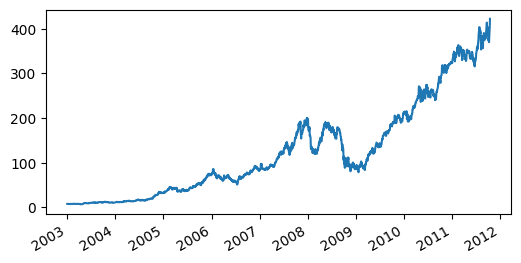

In [68]:
close_px.AAPL.plot()

* I now introduce the ```rolling``` operator, which behaves similarly to ```resample``` and ```groupby```. <br> <br>
* It can be called on a Series or DataFrame along with a ```window```.
  * The following command creates an object that enables grouping over a 250-day window. 
  * So here we have the 250-day moving window average of Apple’s stock price.

In [69]:
type(close_px.AAPL.rolling(250))

pandas.core.window.rolling.Rolling

```python
for chunk in close_px.AAPL.rolling(250):
    print('---------------------------------')
    #print(time)
    print(chunk.shape)
    print(chunk.head())
```

<Axes: >

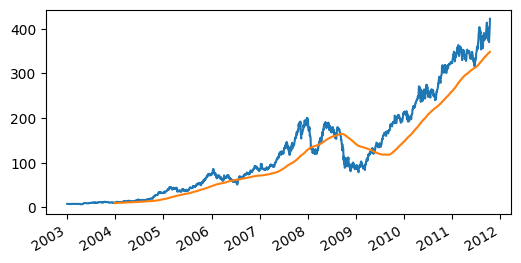

In [70]:
close_px.AAPL.plot()
close_px.AAPL.rolling(250).mean().plot()

* By default rolling functions require all of the values in the window to be non-NA.  <br>
<br>
* This behavior can be changed to account for **missing data** and, in particular, the fact that you will have fewer than window periods of data at the beginning of the time series.

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15    0.077496
2003-01-16    0.074760
2003-01-17    0.112368
Name: AAPL, dtype: float64


<Axes: >

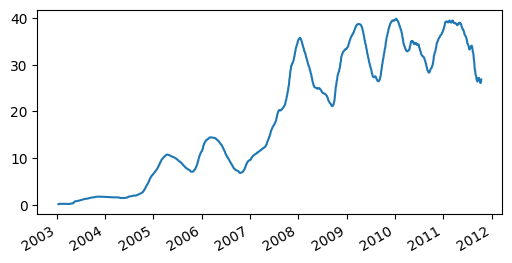

In [81]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
print(appl_std250[5:12])
appl_std250.plot()

* In order to compute an expanding window mean, use the ```expanding``` operator instead of ```rolling```.  <br>
<br>
* The expanding mean starts the time window from the beginning of the time series and increases the size of the window until the end.

<Axes: >

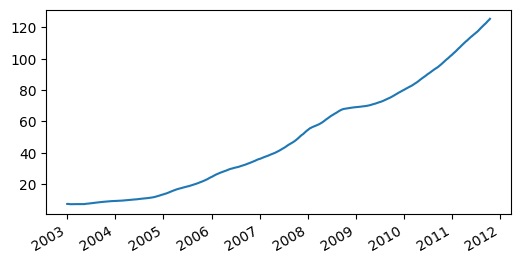

In [72]:
expanding_mean = close_px.AAPL.expanding().mean()
expanding_mean.plot()

Calling a moving window function on a DataFrame applies the transformation to each column

<Axes: >

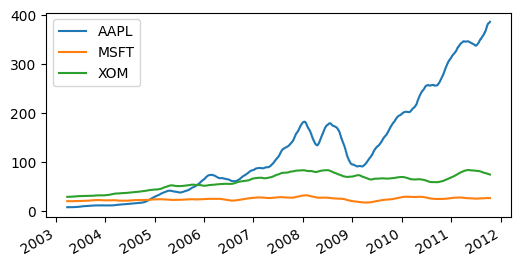

In [83]:
close_px.rolling(60).mean().plot()   # try logy=True

The rolling function also accepts a **string** indicating a fixed-size time offset

<Axes: >

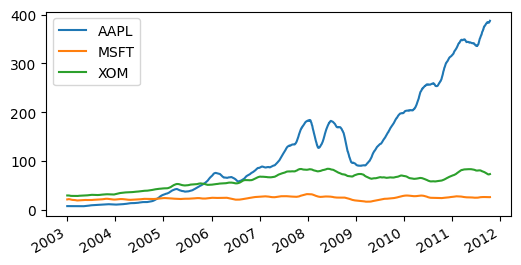

In [89]:
close_px.rolling('60D').mean().plot()

### 9.5.1 Exponentially Weighted Functions (NOT REQUIRED)

An alternative is to **specify a constant decay factor to give more weight to more recent observations**.

pandas has the ```ewm``` (exponentially weighted mean) operator to go along with ```rolling``` and ```expanding```.

More details: https://pandas.pydata.org/docs/reference/api/pandas.Series.ewm.html

In [75]:
aapl_px = close_px.AAPL['2006':'2007']
ma60 = aapl_px.rolling(30, min_periods=20).mean()
ewma60 = aapl_px.ewm(span=30).mean()

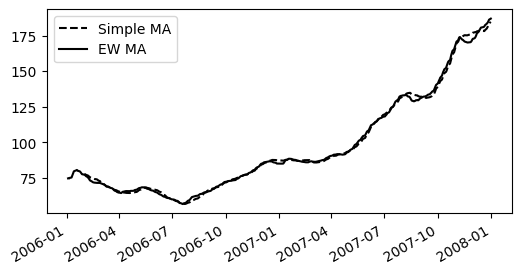

In [76]:
ma60.plot(style='k--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA')
plt.legend()

### 9.5.2 Binary Moving Window Functions

Some statistical operators, like correlation and covariance, need to operate on **two time series**. 
 * As an example, financial analysts are often interested in a stock’s correlation to a benchmark index like the S&P 500.

In [77]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

The ```corr``` aggregation function after we call rolling can then compute the rolling correlation with ```spx_rets```. 

<Axes: >

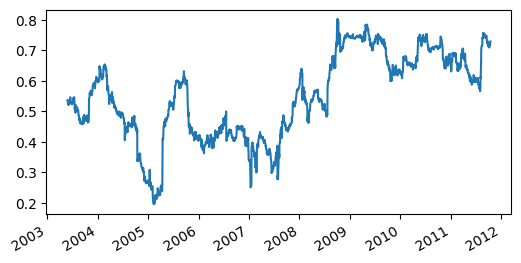

In [78]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

Suppose you wanted to compute the correlation of the S&P 500 index with many stocks at once.

<Axes: >

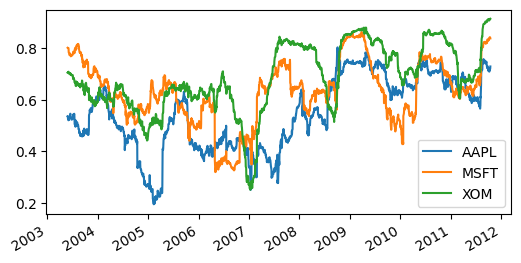

In [79]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

In [80]:
corr

,AAPL,MSFT,XOM
2003-01-02,NaN,NaN,NaN
2003-01-03,NaN,NaN,NaN
2003-01-06,NaN,NaN,NaN
2003-01-07,NaN,NaN,NaN
2003-01-08,NaN,NaN,NaN
...,...,...,...
2011-10-10,0.723203,0.842713,0.913532
2011-10-11,0.717395,0.842764,0.913527
2011-10-12,0.718797,0.841807,0.913912
2011-10-13,0.720945,0.841273,0.913634


---

# END